# Audiobooks - Imbalance Dataset - Business Case Study - Tensorflow 2.0.0
---
Author: Bhaveshkumar Thaker

---

You are given data from an Audiobook App. Logically, it relates to the audio versions of books ONLY. Each customer in the database has made a purchase at least once, that's why he/she is in the database. We want to create a machine learning algorithm based on our available data that can predict if a customer will buy again from the Audiobook company.

The main idea is that if a customer has a low probability of coming back, there is no reason to spend any money on advertising to him/her. If we can focus our efforts SOLELY on customers that are likely to convert again, we can make great savings. Moreover, this model can identify the most important metrics for a customer to come back again. Identifying new customers creates value and growth opportunities.

You have a .csv summarizing the data. There are several variables: Customer ID, ), Book length overall (sum of the minute length of all purchases), Book length avg (average length in minutes of all purchases), Price paid_overall (sum of all purchases) ,Price Paid avg (average of all purchases), Review (a Boolean variable whether the customer left a review), Review out of 10 (if the customer left a review, his/her review out of 10, Total minutes listened, Completion (from 0 to 1), Support requests (number of support requests; everything from forgotten password to assistance for using the App), and Last visited minus purchase date (in days).

These are the inputs (excluding customer ID, as it is completely arbitrary. It's more like a name, than a number).

The targets are a Boolean variable (0 or 1). We are taking a period of 2 years in our inputs, and the next 6 months as targets. So, in fact, we are predicting if: based on the last 2 years of activity and engagement, a customer will convert in the next 6 months. 6 months sounds like a reasonable time. If they don't convert after 6 months, chances are they've gone to a competitor or didn't like the Audiobook way of digesting information.

The task is simple: create a machine learning algorithm, which is able to predict if a customer will buy again.

This is a classification problem with two classes: won't buy and will buy, represented by 0s and 1s.

Good luck!

In [1]:
root_dir = ''
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = '/content/drive/My Drive/Colab Notebooks/tensorflow-2-projects/'
    
    !pip install tensorflow-gpu
except:
    print('No GOOGLE DRIVE connection. Using local dataset(s).')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 380.8MB 56kB/s 
     |████████████████████████████████| 3.8MB 39.9MB/s 
     |████████████████████████████████| 450kB 36.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: t

## Import Libraries

In [0]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [3]:
print(tf.version.VERSION)
print('GPU is', 'available' if tf.config.experimental.list_physical_devices('GPU') else 'NOT AVAILABLE')

2.0.0
GPU is available


In [4]:
seed = 321

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

%matplotlib inline

plt.figure(figsize = (14, 11))
plt.style.use('seaborn')

colors = mcolors.TABLEAU_COLORS
sns.set(rc={'figure.figsize' : (14, 11), 'figure.facecolor': 'whitesmoke', 'axes.facecolor': 'whitesmoke', 'grid.color': 'slategrey'})
sns.color_palette(palette = list(colors.values()));

<Figure size 1008x792 with 0 Axes>

## Load the data

In [5]:
audiobook_dataset = pd.read_csv(root_dir + 'datasets/audiobooks-imbalanced-classification.csv')
audiobook_dataset.head()

,id,book_length_overall_mins,book_length_avg_mins,price_overall,price_avg,review,review_10_by_10,minutes_listened,completion,support_requests,last_visited_minus_purchase_date,targets
0,873,2160.0,2160,10.13,10.13,0,8.91,0.0,0.0,0,0,1
1,611,1404.0,2808,6.66,13.33,1,6.50,0.0,0.0,0,182,1
2,705,324.0,324,10.13,10.13,1,9.00,0.0,0.0,1,334,1
3,391,1620.0,1620,15.31,15.31,0,9.00,0.0,0.0,0,183,1
4,819,432.0,1296,7.11,21.33,1,9.00,0.0,0.0,0,0,1


## Data Insights

In [6]:
audiobook_dataset.shape

(14084, 12)

In [7]:
audiobook_dataset.dtypes

id                                    int64
book_length_overall_mins            float64
book_length_avg_mins                  int64
price_overall                       float64
price_avg                           float64
review                                int64
review_10_by_10                     float64
minutes_listened                    float64
completion                          float64
support_requests                      int64
last_visited_minus_purchase_date      int64
targets                               int64
dtype: object

In [8]:
audiobook_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
id,14084.0,16772.491551,9691.807248,2.00,8368.00,16711.50,25187.25,33683.00
book_length_overall_mins,14084.0,1591.281685,504.340663,216.00,1188.00,1620.00,2160.00,2160.00
book_length_avg_mins,14084.0,1678.608634,654.838599,216.00,1188.00,1620.00,2160.00,7020.00
price_overall,14084.0,7.103791,4.931673,3.86,5.33,5.95,8.00,130.94
price_avg,14084.0,7.543805,5.560129,3.86,5.33,6.07,8.00,130.94
review,14084.0,0.160750,0.367313,0.00,0.00,0.00,0.00,1.00
review_10_by_10,14084.0,8.909795,0.643406,1.00,8.91,8.91,8.91,10.00
minutes_listened,14084.0,0.125659,0.241206,0.00,0.00,0.00,0.13,1.00
completion,14084.0,118.586745,268.731935,0.00,0.00,0.00,64.80,2116.80
support_requests,14084.0,0.070222,0.472157,0.00,0.00,0.00,0.00,30.00


In [9]:
audiobook_dataset.nunique()

id                                  14084
book_length_overall_mins               60
book_length_avg_mins                   58
price_overall                         349
price_avg                             476
review                                  2
review_10_by_10                        24
minutes_listened                      101
completion                             57
support_requests                       12
last_visited_minus_purchase_date      371
targets                                 2
dtype: int64

In [10]:
audiobook_dataset.isnull().sum(axis=0)

id                                  0
book_length_overall_mins            0
book_length_avg_mins                0
price_overall                       0
price_avg                           0
review                              0
review_10_by_10                     0
minutes_listened                    0
completion                          0
support_requests                    0
last_visited_minus_purchase_date    0
targets                             0
dtype: int64

In [11]:
label, count = np.unique(audiobook_dataset['targets'], return_counts=True)

print(np.asarray((label, count)).T)

[[    0 11847]
 [    1  2237]]


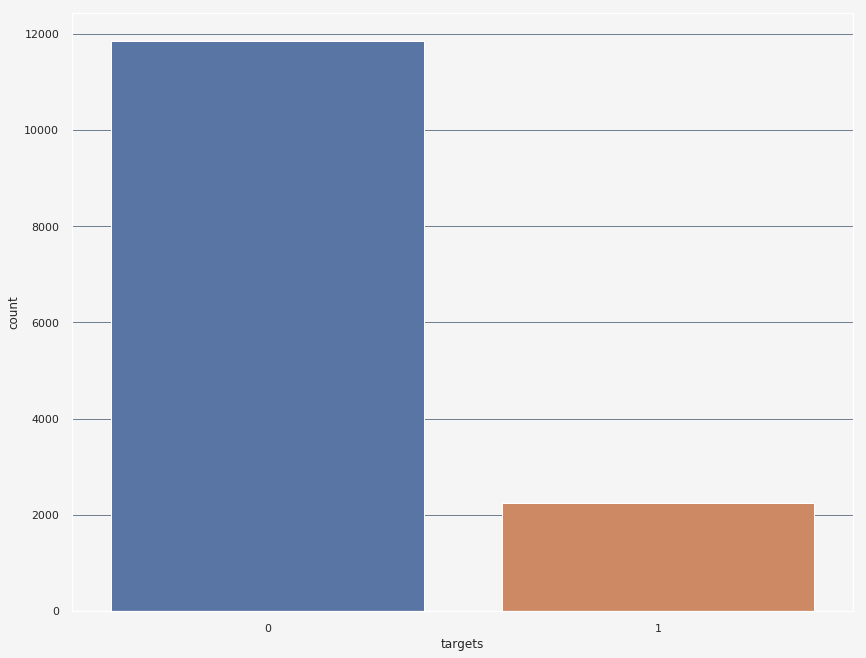

In [12]:
sns.countplot(x=audiobook_dataset['targets'])

## Undersampling

Undersampling is the process where you randomly delete some of the observations from the majority class in order to match the numbers with the minority class.

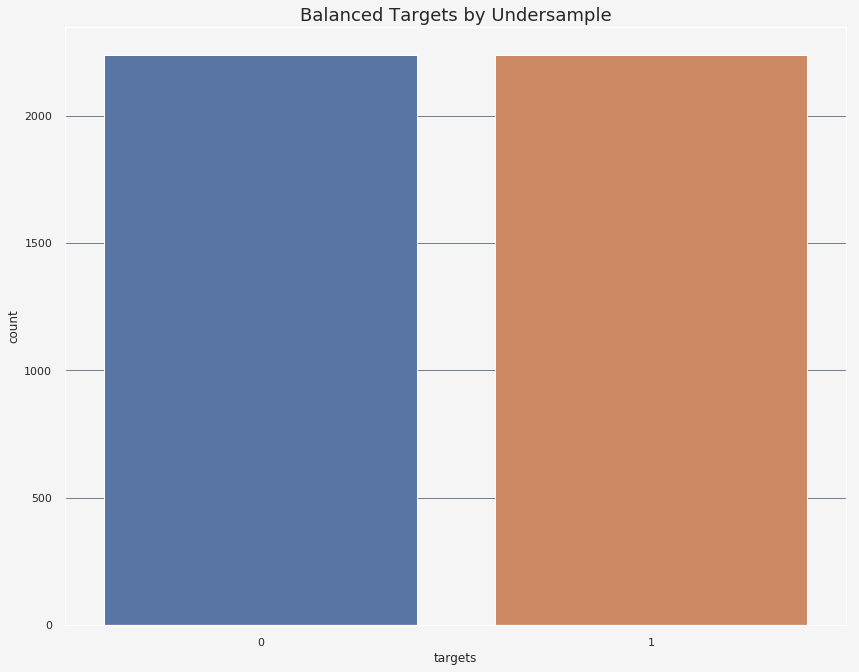

In [13]:
# Shuffle the Dataset.
audiobook_dataset_shuffled = audiobook_dataset.sample(frac=1)

# Put all the minority class in a separate dataset.
audiobook_dataset_minority_class = audiobook_dataset_shuffled.loc[audiobook_dataset_shuffled['targets'] == 1]
len(audiobook_dataset_minority_class)

# Randomly select observations equal to size of minority class from the majority class
length_of_minority_class = len(audiobook_dataset_minority_class)
audiobook_dataset_majority_class = audiobook_dataset_shuffled.loc[audiobook_dataset_shuffled['targets'] == 0].sample(n=length_of_minority_class)
len(audiobook_dataset_majority_class)

# Concatenate both dataframes again
audiobook_dataset_undersampled = pd.concat([audiobook_dataset_minority_class, audiobook_dataset_majority_class])
sns.countplot(x=audiobook_dataset_undersampled['targets'])
plt.title('Balanced Targets by Undersample', fontsize=18)
plt.show()

In [0]:
# The inputs are all columns in the csv, except for the first one and last one
inputs = audiobook_dataset_undersampled.drop(columns=['id', 'targets'])
# The targets are in the last column.
targets = audiobook_dataset_undersampled['targets']

inputs = inputs.astype(np.float64)
targets = targets.astype(np.int64)

## Standardize the inputs

In [0]:
scaled_inputs = preprocessing.scale(inputs)

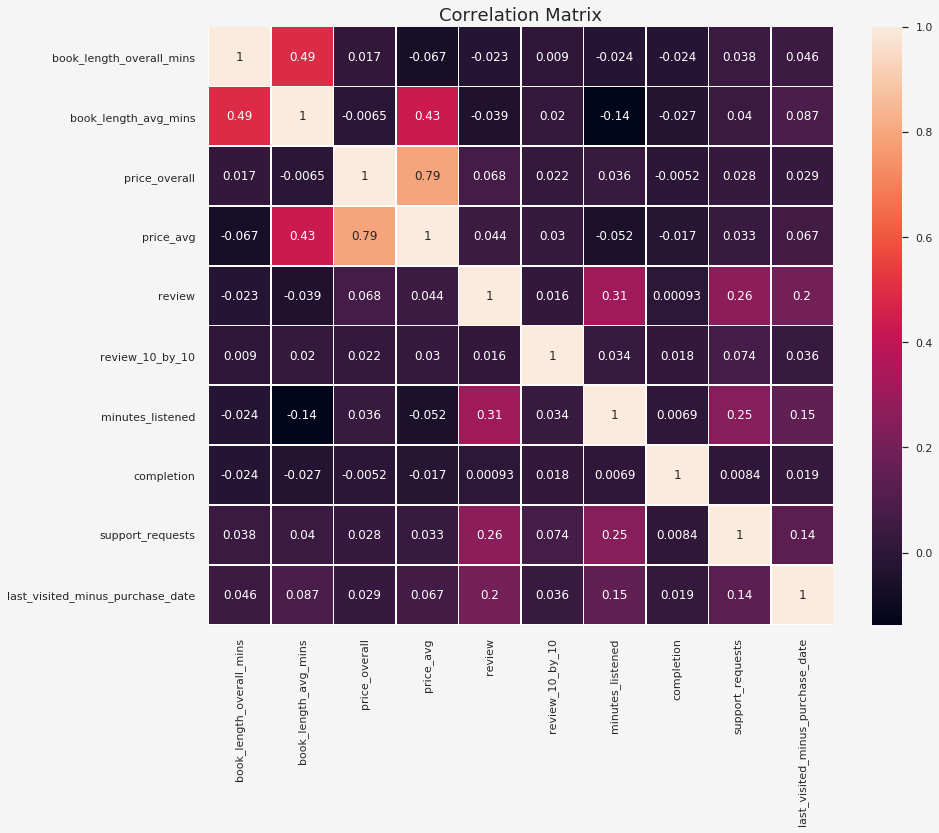

In [16]:
sns.heatmap(inputs.corr(), annot=True, cbar=True, linewidths=0.75)
plt.title('Correlation Matrix', fontsize=18)
plt.show()

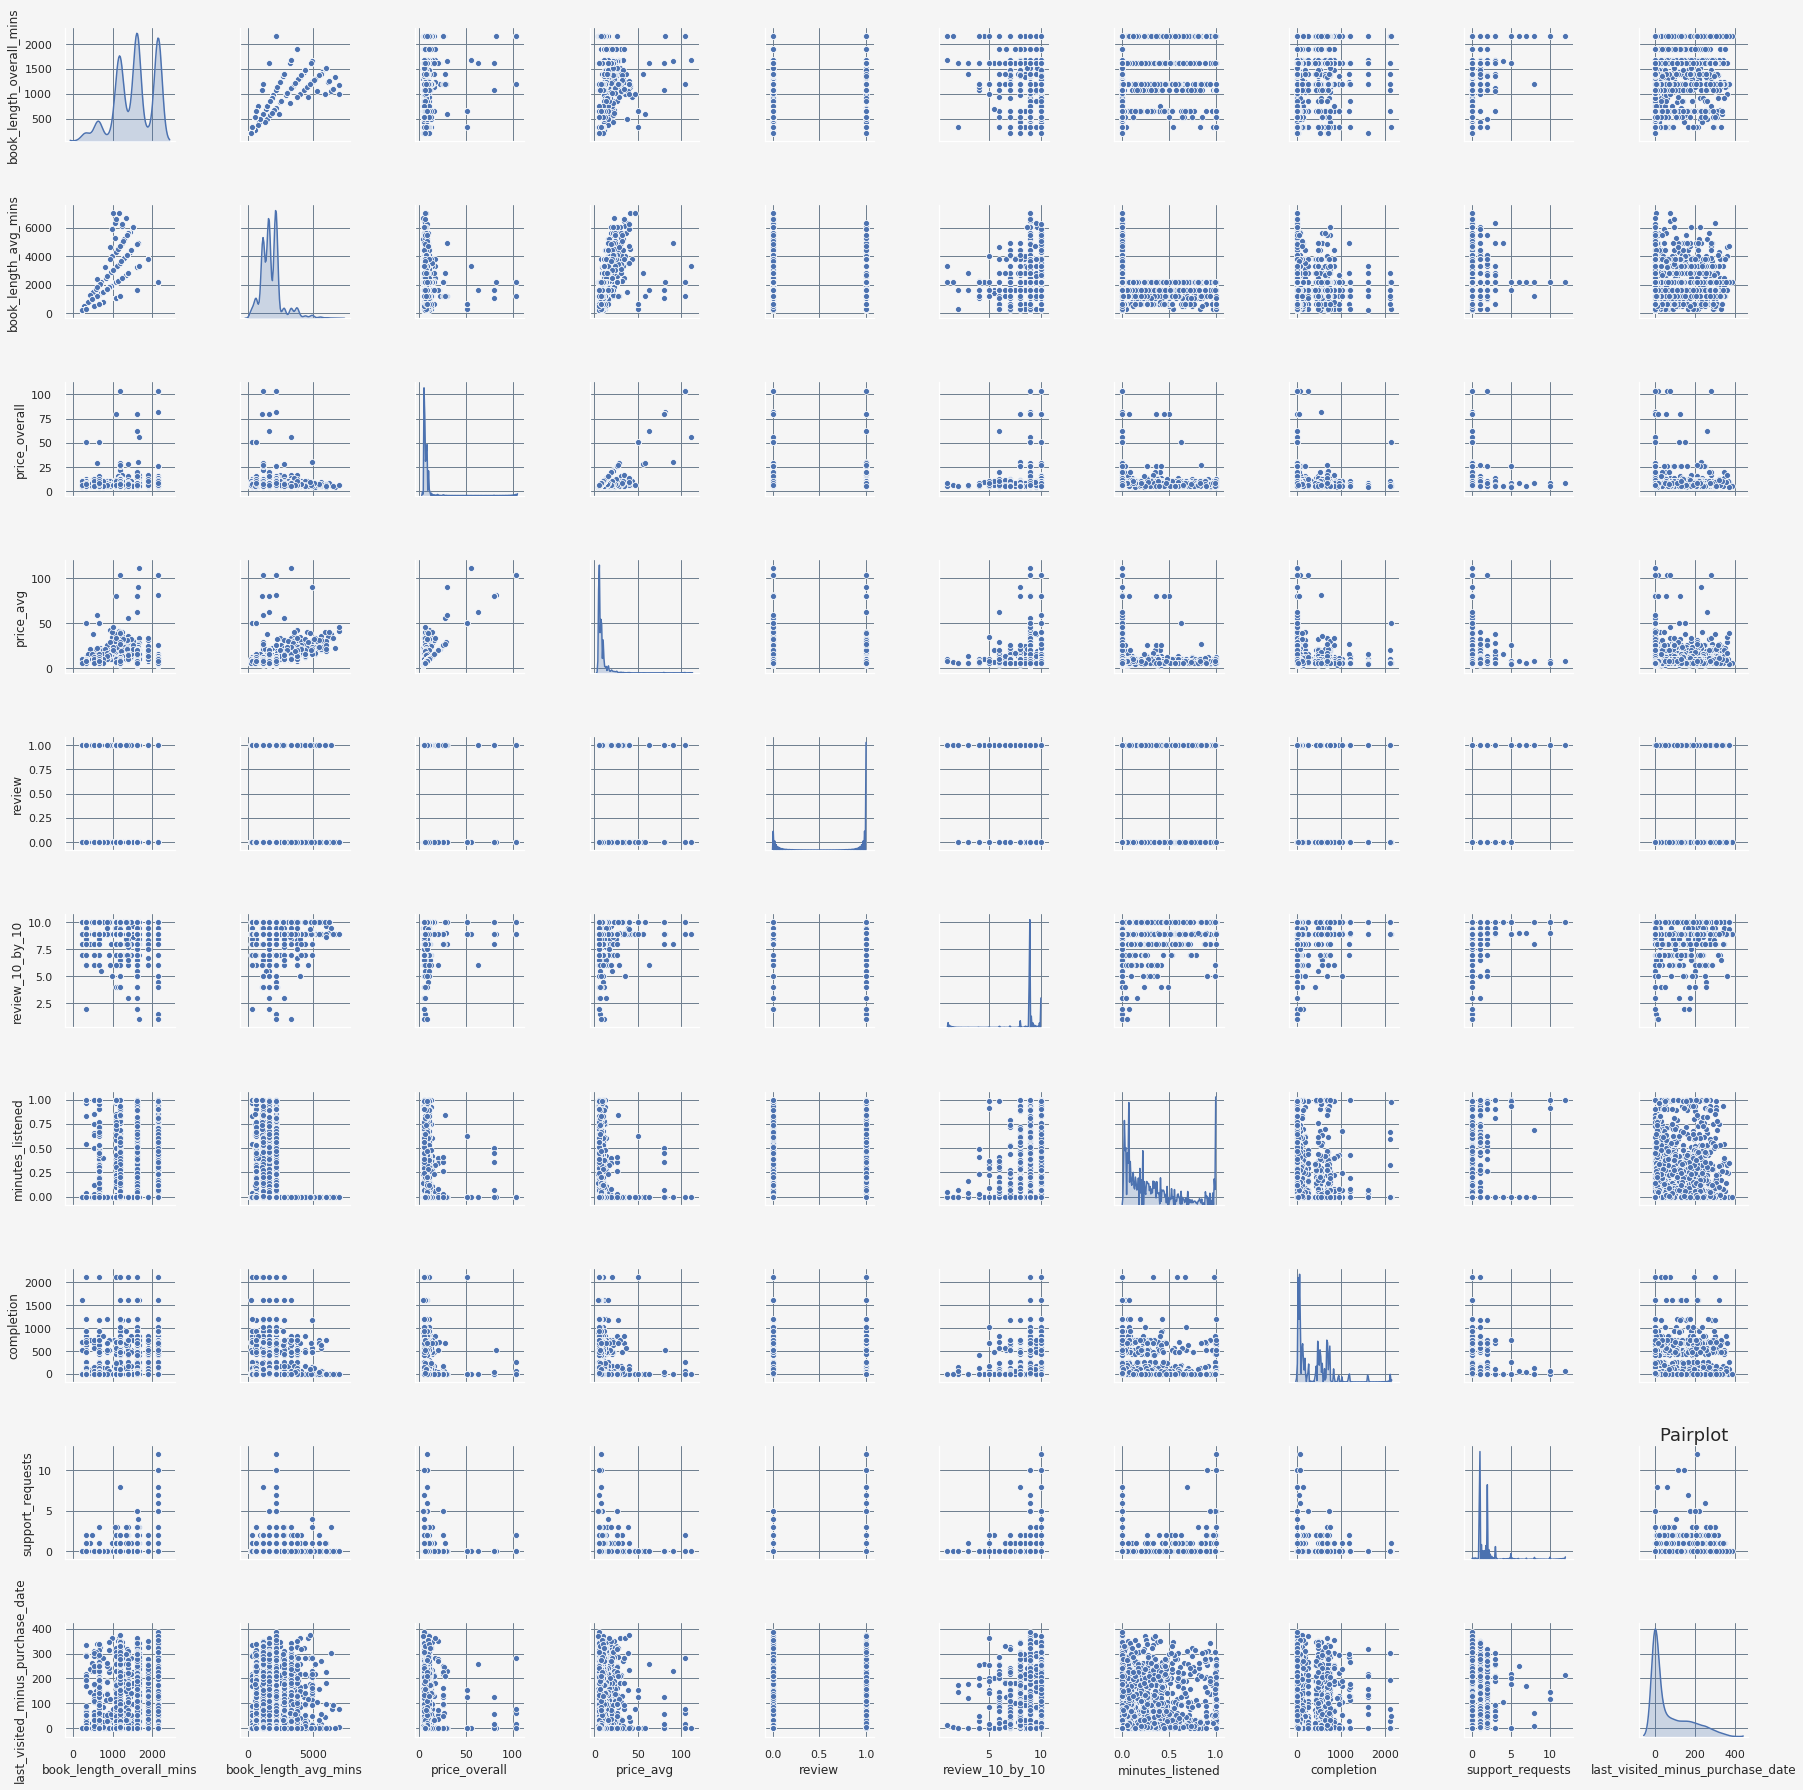

In [17]:
sns.pairplot(inputs, diag_kind = 'kde')
plt.title('Pairplot', fontsize=18)
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size=0.1) #0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11) #0.25

(X_train.shape, X_val.shape, X_test.shape)

((3583, 10), (443, 10), (448, 10))

In [0]:
# Save the three datasets in *.npz.
np.savez('audiobook_us_data_train.npz', inputs=X_train, targets=y_train)
np.savez('audiobook_us_data_val.npz', inputs=X_val, targets=y_val)
np.savez('audiobook_us_data_test.npz', inputs=X_test, targets=y_test)

# Load all three datasets in temporary variables
train_dataset = np.load('audiobook_us_data_train.npz')
validation_dataset = np.load('audiobook_us_data_val.npz')
test_dataset = np.load('audiobook_us_data_test.npz')

train_inputs = train_dataset['inputs'].astype(np.float)
train_targets = train_dataset['targets'].astype(np.int)

validation_inputs, validation_targets = validation_dataset['inputs'].astype(np.float), validation_dataset['targets'].astype(np.int)
test_inputs, test_targets = test_dataset['inputs'].astype(np.float), test_dataset['targets'].astype(np.int)

## Model

In [20]:
# Set the input and output sizes
input_size = 10
output_size = 2
# Useing same hidden layer size for all hidden layers.
hidden_layer_size = 64

# Define the model
model = tf.keras.Sequential([tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(output_size, activation='softmax')
                            ])
# Choose the optimizer, the loss function and the metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set the batch size
batch_size = 100
# Set a maximum number of training epochs
max_epochs = 100
# Set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# Fit the model
model.fit(train_inputs,
          train_targets,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_targets),
          verbose = 2
          )

Train on 3583 samples, validate on 443 samples
Epoch 1/100
3583/3583 - 2s - loss: 0.5912 - accuracy: 0.6924 - val_loss: 0.5055 - val_accuracy: 0.7246
Epoch 2/100
3583/3583 - 0s - loss: 0.4402 - accuracy: 0.7697 - val_loss: 0.4340 - val_accuracy: 0.7968
Epoch 3/100
3583/3583 - 0s - loss: 0.4008 - accuracy: 0.7935 - val_loss: 0.4051 - val_accuracy: 0.7968
Epoch 4/100
3583/3583 - 0s - loss: 0.3803 - accuracy: 0.8024 - val_loss: 0.3934 - val_accuracy: 0.8059
Epoch 5/100
3583/3583 - 0s - loss: 0.3704 - accuracy: 0.8018 - val_loss: 0.3745 - val_accuracy: 0.8172
Epoch 6/100
3583/3583 - 0s - loss: 0.3657 - accuracy: 0.8002 - val_loss: 0.3770 - val_accuracy: 0.7991
Epoch 7/100
3583/3583 - 0s - loss: 0.3607 - accuracy: 0.8119 - val_loss: 0.3798 - val_accuracy: 0.8172


## Test the model

In [21]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

448/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Oversampling

Oversampling is the process of generating synthetic data that tries to randomly generate a sample of the attributes from observations in the minority class.

In [22]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
smote = SMOTE(sampling_strategy='minority')
inputs, targets = smote.fit_sample(audiobook_dataset_shuffled.drop(columns=['id', 'targets']), audiobook_dataset_shuffled['targets'])

inputs = inputs.astype(np.float64)
targets = targets.astype(np.int64)

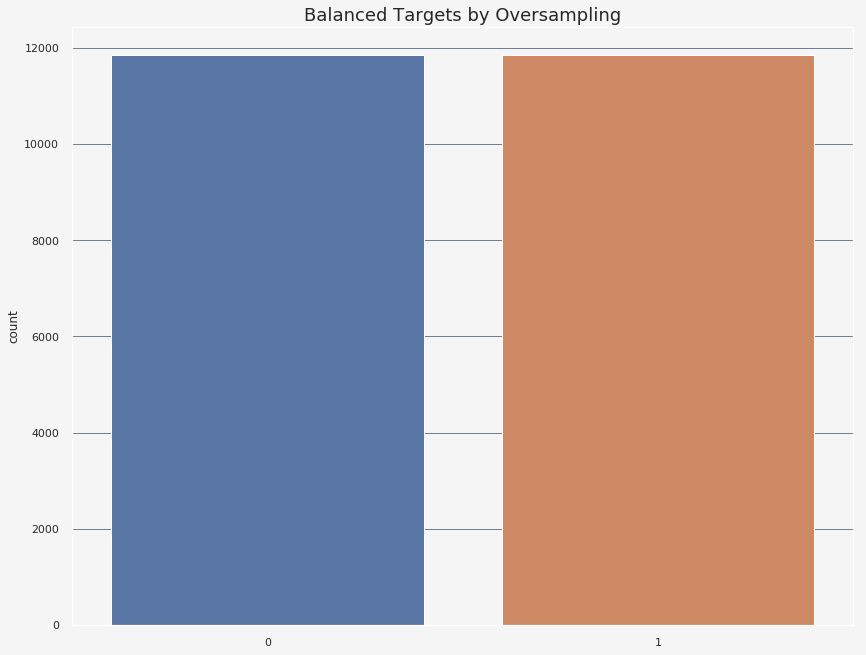

In [24]:
sns.countplot(x=targets)
plt.title('Balanced Targets by Oversampling', fontsize=18)
plt.show()

In [0]:
standardScaler = StandardScaler()
scaled_inputs = standardScaler.fit_transform(inputs)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(scaled_inputs, targets, test_size=0.1) #0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11) #0.25

(X_train.shape, X_val.shape, X_test.shape)

((18978, 10), (2346, 10), (2370, 10))

In [0]:
# Save the three datasets in *.npz.
np.savez('audiobook_os_data_train.npz', inputs=X_train, targets=y_train)
np.savez('audiobook_os_data_val.npz', inputs=X_val, targets=y_val)
np.savez('audiobook_os_data_test.npz', inputs=X_test, targets=y_test)

# Load all three datasets in temporary variables
train_dataset = np.load('audiobook_os_data_train.npz')
validation_dataset = np.load('audiobook_os_data_val.npz')
test_dataset = np.load('audiobook_os_data_test.npz')

train_inputs, train_targets = train_dataset['inputs'].astype(np.float), train_dataset['targets'].astype(np.int)
validation_inputs, validation_targets = validation_dataset['inputs'].astype(np.float), validation_dataset['targets'].astype(np.int)

test_inputs, test_targets = test_dataset['inputs'].astype(np.float), test_dataset['targets'].astype(np.int)

In [28]:
# Set the input and output sizes
input_size = 10
output_size = 2
# Useing same hidden layer size for all hidden layers.
hidden_layer_size = 64

# Define the model
model = tf.keras.Sequential([tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                             tf.keras.layers.Dense(output_size, activation='softmax')
                            ])
# Choose the optimizer, the loss function and the metrics
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set the batch size
batch_size = 100
# Set a maximum number of training epochs
max_epochs = 100
# Set an early stopping mechanism
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# Fit the model
model.fit(train_inputs,
          train_targets,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_targets),
          verbose = 2
          )

Train on 18978 samples, validate on 2346 samples
Epoch 1/100
18978/18978 - 1s - loss: 0.4499 - accuracy: 0.7644 - val_loss: 0.3923 - val_accuracy: 0.8009
Epoch 2/100
18978/18978 - 1s - loss: 0.3607 - accuracy: 0.8056 - val_loss: 0.3555 - val_accuracy: 0.8120
Epoch 3/100
18978/18978 - 1s - loss: 0.3511 - accuracy: 0.8091 - val_loss: 0.3551 - val_accuracy: 0.8146
Epoch 4/100
18978/18978 - 1s - loss: 0.3389 - accuracy: 0.8156 - val_loss: 0.3406 - val_accuracy: 0.8154
Epoch 5/100
18978/18978 - 1s - loss: 0.3385 - accuracy: 0.8156 - val_loss: 0.3382 - val_accuracy: 0.8223
Epoch 6/100
18978/18978 - 1s - loss: 0.3357 - accuracy: 0.8188 - val_loss: 0.3371 - val_accuracy: 0.8201
Epoch 7/100
18978/18978 - 1s - loss: 0.3317 - accuracy: 0.8205 - val_loss: 0.3297 - val_accuracy: 0.8248
Epoch 8/100
18978/18978 - 1s - loss: 0.3266 - accuracy: 0.8227 - val_loss: 0.3307 - val_accuracy: 0.8227
Epoch 9/100
18978/18978 - 1s - loss: 0.3258 - accuracy: 0.8207 - val_loss: 0.3408 - val_accuracy: 0.8142


In [29]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

2370/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================